In [32]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import random
import time
import pickle
import sys
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression as LR, Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
import statsmodels.api as sm
from sklearn.model_selection import KFold,cross_val_score

%matplotlib inline
sys.setrecursionlimit(50000)

In [25]:
df_movies = pd.read_csv('Movies_List_v4.csv')
print(df_movies.columns)
print(df_movies.info())


features_list = ['Opening Weekend Theatres', 'Budget', 'Franchise', 'Brand', \
                 'All Audience', 'Adult Audience', 'Big_Studio', 'Blockbuster_Season', 'Dump_Season', \
                 'Years Since', 'Action', 'Adventure', 'Comedy', 'Drama', 'Horror', \
                 'Romance', 'Thriller', 'High Fiction', 'Non-Fiction']
# 'Running Length',
target = 'Opening Weekend Gross'


X = df_movies[features_list].copy(deep=True)
y = df_movies[target].copy(deep=True)

#Train Test Split
X_train_val, X_test, y_train_val, y_test = train_test_split(X,y,test_size=0.2)

Index(['Release Link', 'Title', 'Domestic Gross', 'Max Theatres',
       'Opening Weekend Gross', 'Domestic to Opening Gross',
       'Opening Weekend Theatres', 'Release Date', 'Studio Link',
       'Studio Name', 'Title ID', 'Running Length', 'Budget', 'MPAA', 'Genre',
       'Franchise', 'Brand', 'Genre_List', 'Action', 'Adventure', 'Comedy',
       'Drama', 'Horror', 'Romance', 'Thriller', 'High Fiction', 'Non-Fiction',
       'All Audience', 'Adult Audience', 'Big_Studio', 'Blockbuster_Season',
       'Dump_Season', 'Years Since'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2324 entries, 0 to 2323
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Release Link               2324 non-null   object 
 1   Title                      2324 non-null   object 
 2   Domestic Gross             2324 non-null   int64  
 3   Max Theatres               2324 non-null   

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val,y_train_val,test_size=0.2)

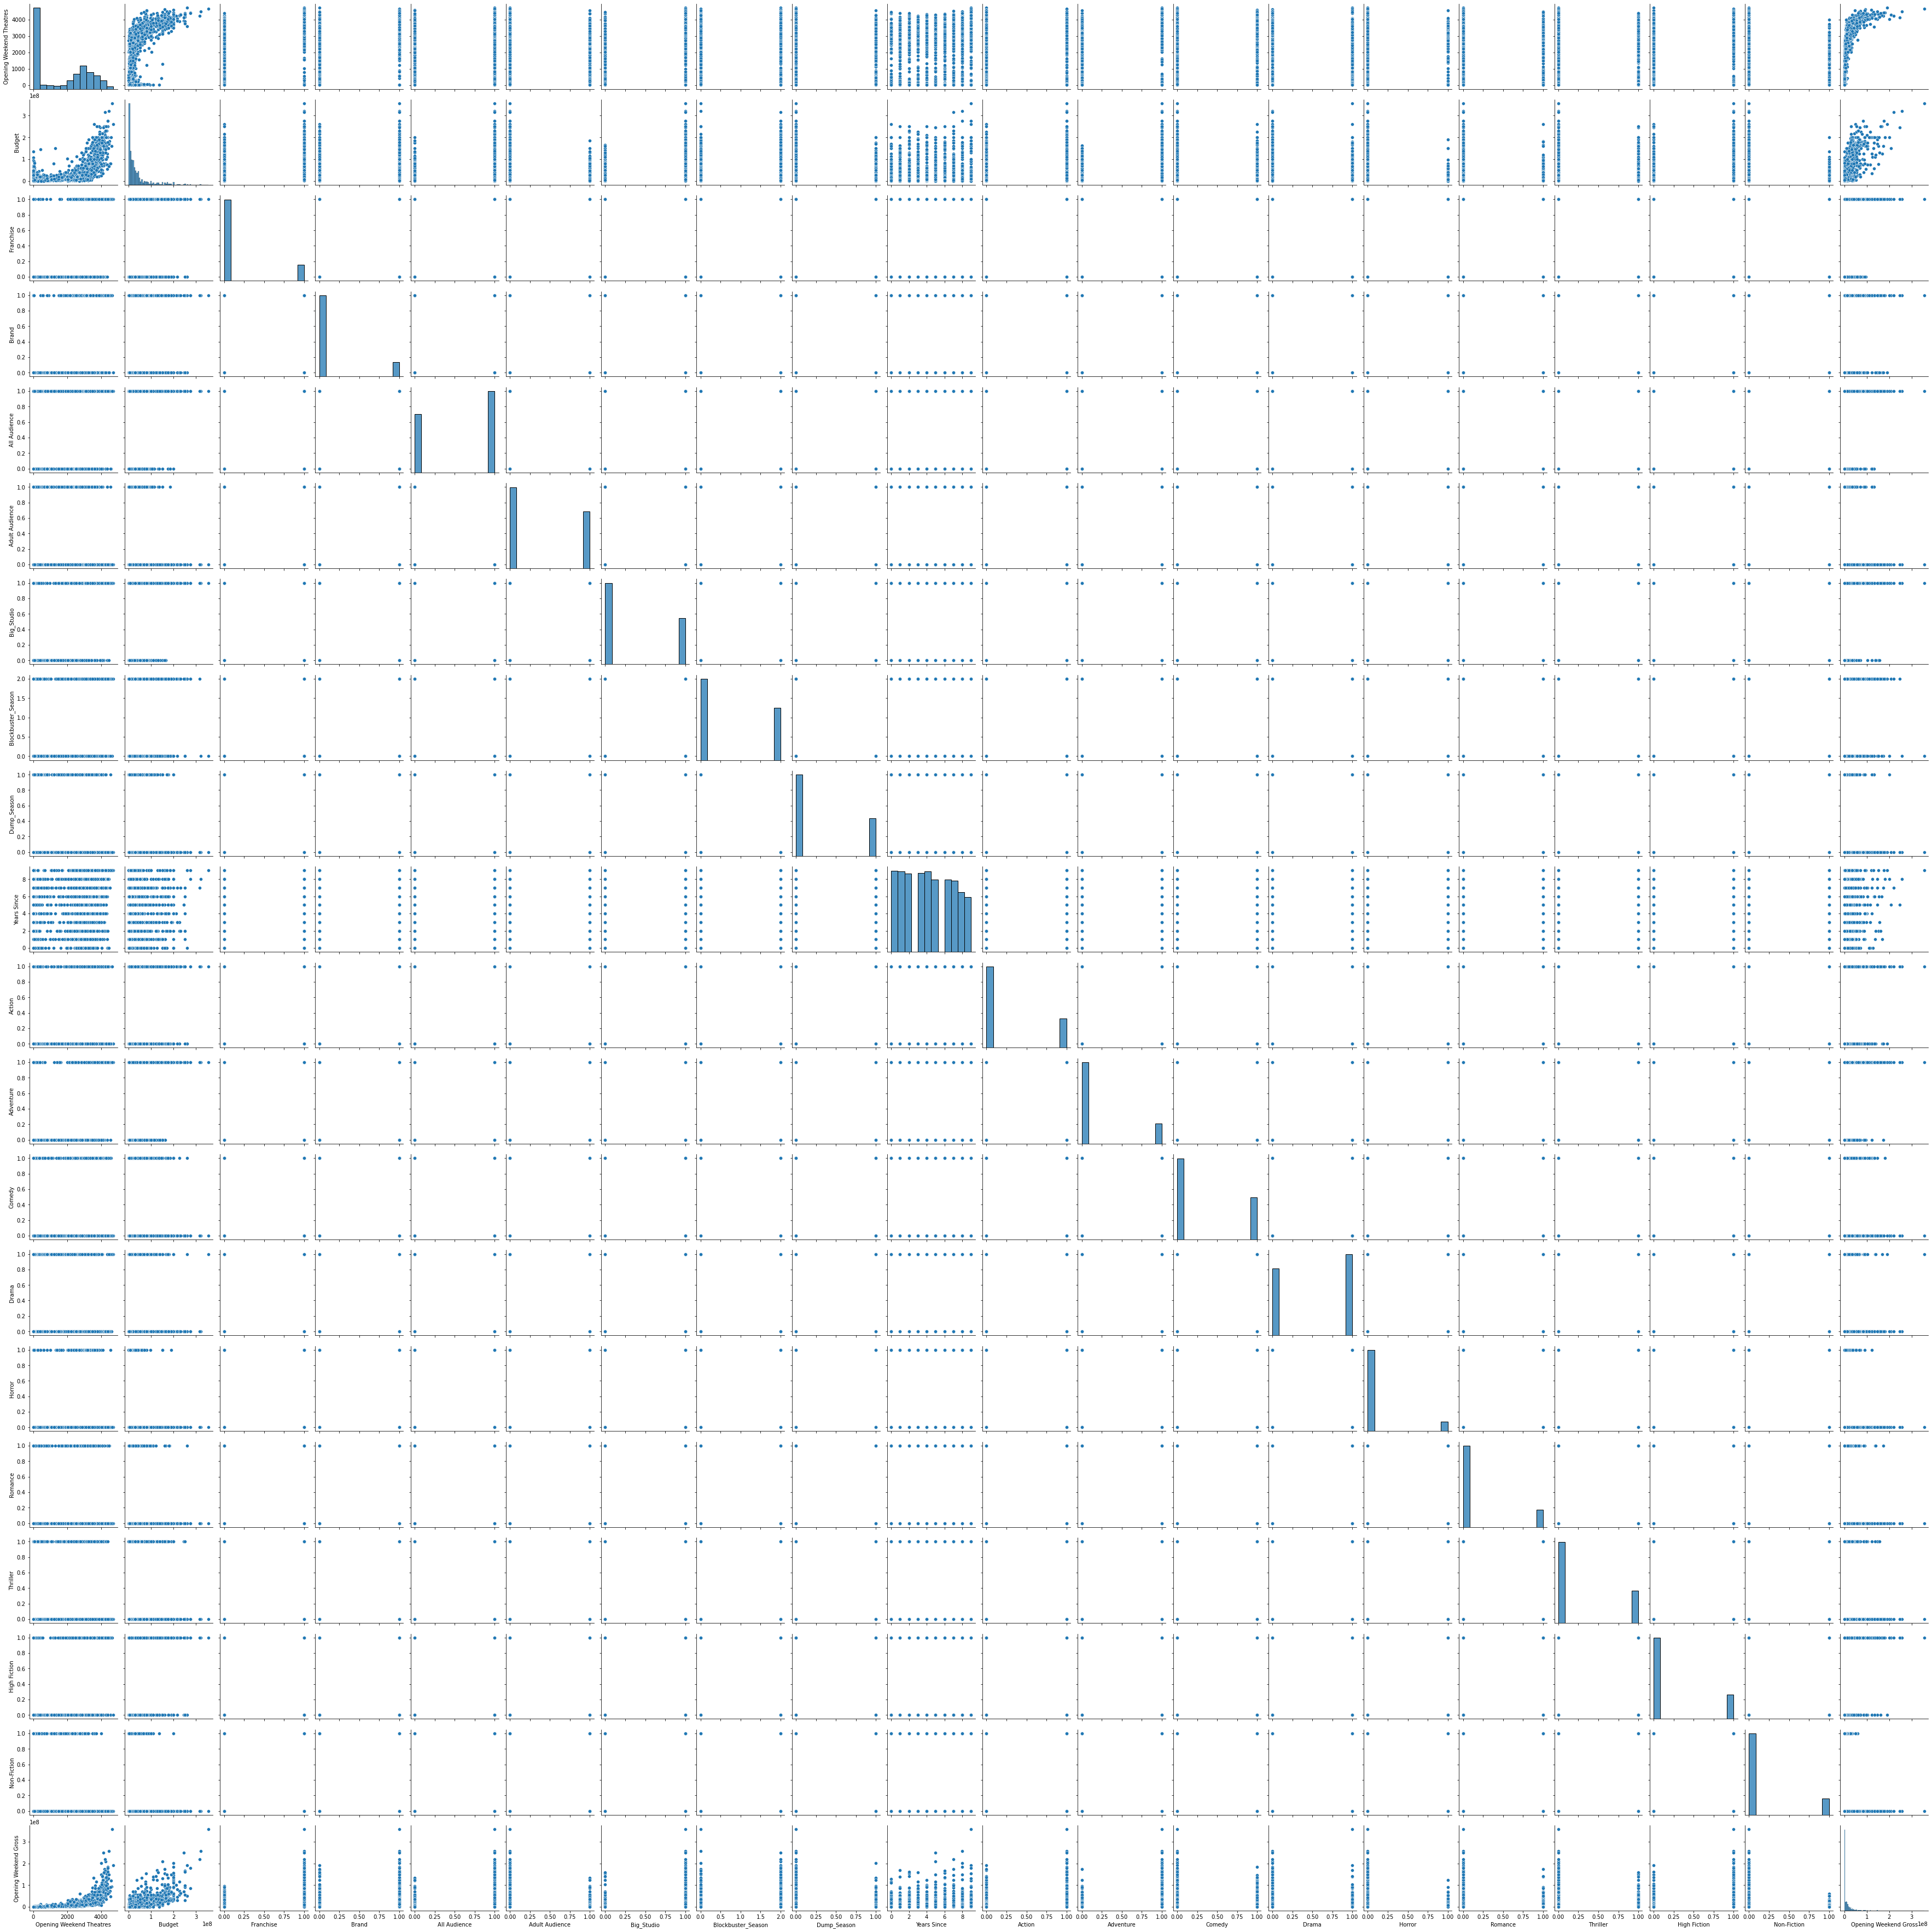

In [212]:
# sns.pairplot(data=pd.concat([X_train,y_train],axis=1))


<AxesSubplot:xlabel='Opening Weekend Theatres', ylabel='Budget'>

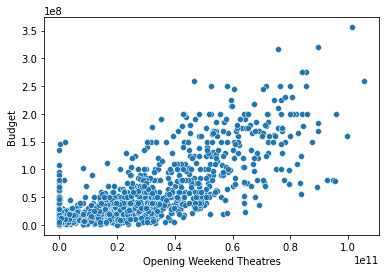

In [224]:
sns.scatterplot(x=(X_train['Opening Weekend Theatres'])**3,y=X_train['Budget'])

In [5]:
X_train['OWT**3'] = X_train['Opening Weekend Theatres']**3
X_val['OWT**3'] = X_val['Opening Weekend Theatres']**3

<ipython-input-5-b3fce6fbd187>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['OWT**3'] = X_train['Opening Weekend Theatres']**3
<ipython-input-5-b3fce6fbd187>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['OWT**3'] = X_val['Opening Weekend Theatres']**3


In [40]:

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_r2s, cv_lm_reg_r2s = [], [] #collect the validation results for both models

X_tr_val, y_tr_val = np.array(X_train_val),np.array(y_train_val)

for train_ind, val_ind in kf.split(X_tr_val,y_tr_val):
    
    X_train, y_train = X_tr_val[train_ind], y_tr_val[train_ind]
    X_val, y_val = X_tr_val[val_ind], y_tr_val[val_ind] 
    
    #simple linear regression
    lm = LR()
    lm_reg = Ridge(alpha=50)

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))
    
    #ridge with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))

print('Simple regression scores: ', cv_lm_r2s)
print('Ridge scores: ', cv_lm_reg_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')

Simple regression scores:  [0.6169069790549431, 0.6107053596209135, 0.6230905280507189, 0.6738225322783558, 0.6713401458148861]
Ridge scores:  [0.6260671581851269, 0.6072493272050246, 0.6277117195570562, 0.6775227773643042, 0.6650058158766337] 

Simple mean cv r^2: 0.639 +- 0.028
Ridge mean cv r^2: 0.641 +- 0.026


In [ ]:
from sklearn.model_selection import cross_val_score
lm = LinearRegression()

cross_val_score(lm, X, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2')
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cross_val_score(lm, X, y, cv=kf, scoring='r2')


In [14]:
# plt.figure(figsize=(14,14))

# sns.heatmap(X_train.corr(),cmap="seismic",annot=True, vmin=-1, vmax=1)

# plt.gca().set_ylim(len(X_train.corr())+0.5, -0.5); 

X_train.corr()['']

,Opening Weekend Theatres,Budget,Franchise,Brand,All Audience,Adult Audience,Big_Studio,Blockbuster_Season,Dump_Season,Years Since,Action,Adventure,Comedy,Drama,Horror,Romance,Thriller,High Fiction,Non-Fiction,OWT**3
Opening Weekend Theatres,1.000000,0.657128,0.500838,0.392501,0.145651,-0.155804,0.688621,0.041984,0.025380,0.118013,0.316676,0.417371,0.123337,-0.351963,0.065007,-0.081292,0.100577,0.375378,-0.259130,0.909850
Budget,0.657128,1.000000,0.461986,0.411065,0.209460,-0.221139,0.555457,0.199465,-0.117425,0.026379,0.419627,0.597570,-0.012680,-0.263183,-0.131116,-0.109900,-0.023663,0.521442,-0.153739,0.792240
Franchise,0.500838,0.461986,1.000000,0.331510,0.099218,-0.109864,0.372676,0.056751,-0.045049,0.078637,0.248952,0.368165,0.052018,-0.311703,0.080104,-0.134916,0.064253,0.282775,-0.183179,0.597798
Brand,0.392501,0.411065,0.331510,1.000000,0.118728,-0.138211,0.342131,0.048925,-0.062157,0.074311,0.134929,0.340537,0.056396,-0.228019,0.074459,-0.075143,-0.024920,0.303508,-0.099988,0.458549
All Audience,0.145651,0.209460,0.099218,0.118728,1.000000,-0.988954,0.115754,0.005971,0.074326,0.014327,0.009772,0.246480,0.013974,-0.078148,-0.216991,0.060646,-0.203459,0.178560,0.080753,0.192005
Adult Audience,-0.155804,-0.221139,-0.109864,-0.138211,-0.988954,1.000000,-0.128141,-0.011422,-0.066754,-0.019711,-0.003278,-0.255537,-0.020522,0.090191,0.221349,-0.055693,0.210896,-0.179669,-0.086622,-0.207119
Big_Studio,0.688621,0.555457,0.372676,0.342131,0.115754,-0.128141,1.000000,0.123809,-0.063285,0.077742,0.184191,0.299100,0.142137,-0.232025,-0.021662,-0.044770,-0.033106,0.269188,-0.128879,0.672849
Blockbuster_Season,0.041984,0.199465,0.056751,0.048925,0.005971,-0.011422,0.123809,1.000000,-0.556086,0.023288,-0.000353,0.086985,0.075470,-0.032129,-0.070265,0.007925,-0.087398,0.046275,0.005698,0.118651
Dump_Season,0.025380,-0.117425,-0.045049,-0.062157,0.074326,-0.066754,-0.063285,-0.556086,1.000000,0.009843,0.028488,-0.020606,-0.027372,0.015957,0.042734,0.024802,0.048608,-0.004464,-0.018887,-0.044140
Years Since,0.118013,0.026379,0.078637,0.074311,0.014327,-0.019711,0.077742,0.023288,0.009843,1.000000,0.040284,0.067686,-0.024804,-0.022656,0.055339,-0.106528,0.080680,0.050851,0.054173,0.117306


In [319]:
X_train.shape

(1487, 21)

In [372]:
X_train = sm.add_constant(X_train)

stats_model = sm.OLS(y_train,X_train[['const']+cols])

stats_model = stats_model.fit()

stats_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Opening Weekend Gross   R-squared:                       0.694
Model:                               OLS   Adj. R-squared:                  0.693
Method:                    Least Squares   F-statistic:                     479.8
Date:                   Wed, 07 Oct 2020   Prob (F-statistic):               0.00
Time:                           19:12:32   Log-Likelihood:                -26556.
No. Observations:                   1487   AIC:                         5.313e+04
Df Residuals:                       1479   BIC:                         5.317e+04
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.779e+06   5.15e+05     -3.452      0.001   -2.79e+06   -7.68e+05
Budget           0.1995      0.014     14.762      0.000       0.173       0.226
Franchise     1.136e+07   1.27e+06      8.947      0.000    8.87e+06    1.39e+07
Brand         5.798e+06   1.15e+06      5.037      0.000    3.54e+06    8.06e+06
Adventure    -3.896e+06   1.25e+06     -3.122      0.002   -6.34e+06   -1.45e+06
Comedy       -2.701e+06   7.76e+05     -3.483      0.001   -4.22e+06   -1.18e+06
High Fiction -4.153e+06   1.07e+06     -3.889      0.000   -6.25e+06   -2.06e+06
OWT**3           0.0005   3.21e-05     15.018      0.000       0.000       0.001
==============================================================================
Omnibus:                     1276.700   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            59026.857
Skew:                           3.746   Prob(JB):                         0.00
Kurtosis:                      32.943   Cond. No.                     1.00e+11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  1e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [370]:
cols = ['Budget', 'Franchise', 'Brand', \
                 
                 'Adventure', 'Comedy', \
                   'High Fiction','OWT**3']
# print(X_train.shape)

lr_model = LR()
lr_model.fit(X_train[cols],y_train)

print("Train Score: {}".format(lr_model.score(X_train[cols],y_train)))
print("Test Score: {}".format(lr_model.score(X_val[cols],y_val)))

lr_model.coef_

Train Score: 0.6942679939003347
Test Score: 0.6583690198398898


array([ 1.99493907e-01,  1.13640408e+07,  5.79774158e+06, -3.89631528e+06,
       -2.70137483e+06, -4.15284616e+06,  4.81884927e-04])

In [272]:

print(X_train.shape)

lr_model = LR()
lr_model.fit(X_train,y_train)

print("Train Score: {}".format(lr_model.score(X_train,y_train)))
print("Test Score: {}".format(lr_model.score(X_val,y_val)))


(1487, 20)
Train Score: 0.7164589989700605
Test Score: 0.6353164702946891


In [371]:
pf = PolynomialFeatures(degree=2)
X_train_poly = pf.fit_transform(X_train[cols])
X_val_poly = pf.transform(X_val[cols])


lr_model_poly = LR()
lr_model_poly.fit(X_train_poly,y_train)

print("Train Score: {}".format(lr_model_poly.score(X_train_poly,y_train)))
print("Test Score: {}".format(lr_model_poly.score(X_val_poly,y_val)))


Train Score: 0.8007415936444757
Test Score: 0.7931450211522014


<AxesSubplot:xlabel='Opening Weekend Gross', ylabel='Opening Weekend Gross'>

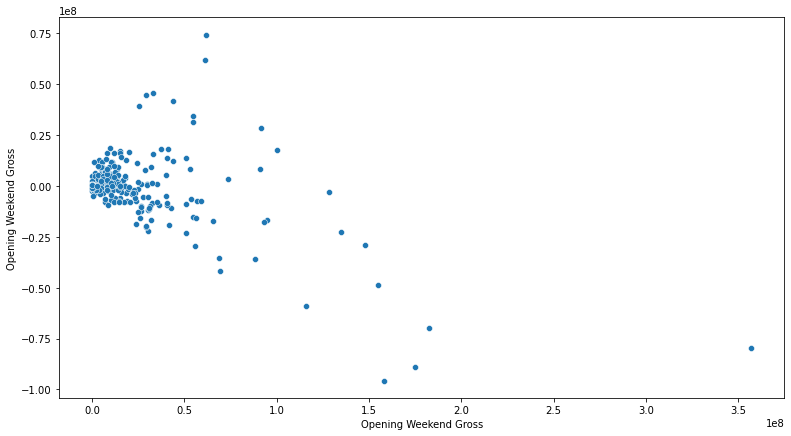

In [362]:
residuals = lr_model_poly.predict(X_val_poly) - y_val


plt.figure(figsize=(13,7))
# sns.scatterplot(x=y_test_pred,label="Predicted Values",alpha=0.4)
# sns.scatterplot(data=np.array(y_test),label="True Values",alpha=0.7)

sns.scatterplot(x=y_val,y=residuals)

# sns.scatterplot(x=y_test,y=residuals)
# y_test
# y_test

(-10000000.0, 0.0)

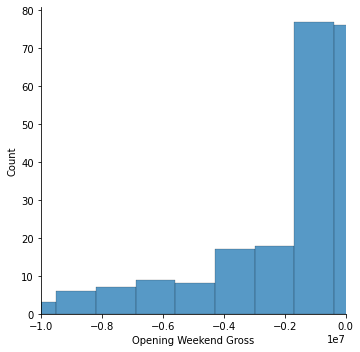

In [289]:
# errors = (np.array(y_test) - y_test_pred)
g=sns.displot(data=residuals)
g.ax.set_xlim(-1*10**7,1*0**7)

In [41]:
# Graph to plot y_preds vs y_actual with a line through the middle, indicating perfect capture of values.

plt.scatter(test_set_pred, y_test, alpha=.1)
plt.plot(np.linspace(0,600000,1000), np.linspace(0,600000,1000))

NameError: name 'test_set_pred' is not defined